A spatial proteomics simplefied pipeline for marker-to-marker translation with leave-one-marker-out: 

*   Inputs: multiplexed tissue images with varying markers panels. Data was uploaded to Kaggle.  
*   Preprocessing: normalize intensities by regressing each channel on available chromatin markers (DNA and core histones) and compute residuals, then apply PCA to project residuals into a 3-channel representation compatible with Resnet50. 
*   Encoder: pretrained Resnet50 (partially frozen) to extract morphological features. 
*   Decoder: U-Net with bilinear upsampling to reconstruct the left-out marker/channel.

# imports

In [1]:
!pip install pytorch_msssim
!pip install imagecodecs
!pip install torchmetrics
!pip install clean-fid
!pip install optuna

#!pip install torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import os
import tifffile
import zipfile
import imagecodecs
import tempfile
import pickle
import json
import imageio
import sys
import psutil
import shutil
import numpy as np
import pandas as pd
import gc
import time
import glob
from collections import Counter, OrderedDict
import cv2
import random
from scipy.stats import pearsonr
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.parametrizations import weight_norm
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
import skimage.transform
from pytorch_msssim import ssim
from tqdm import tqdm
import torchvision.utils as vutils
from cleanfid import fid
import optuna
from optuna.trial import Trial
#from torchmetrics.image.fid import FrechetInceptionDistance


import matplotlib.pyplot as plt
params = {'axes.titlesize': 30,
          'legend.fontsize': 16,
          'figure.figsize': (16, 10),
          'axes.labelsize': 16,
          'axes.titlesize': 12,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'figure.titlesize': 30}

plt.rcParams.update(params)
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(device)
#print(torch.cuda.get_device_name(0))
#print(f"Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
#print(f"Cached: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
#print(f"Max allocated: {torch.cuda.max_memory_allocated(0)/1024**2:.2f} MB")
#!free -h

In [4]:
INPUT_CACHE_ROOT = "/kaggle/input/your-notebook-output-files/cv_cache"  # from the “Add Data” you attached
WORK_CACHE_ROOT  = "/kaggle/working/cv_cache"

# restore previous cache if present
if os.path.exists(INPUT_CACHE_ROOT):
    os.makedirs(WORK_CACHE_ROOT, exist_ok=True)
    for src in glob.glob(os.path.join(INPUT_CACHE_ROOT, "**/*"), recursive=True):
        if os.path.isfile(src):
            dst = src.replace(INPUT_CACHE_ROOT, WORK_CACHE_ROOT, 1)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy2(src, dst)
    print(f"[init] Restored cache from {INPUT_CACHE_ROOT} -> {WORK_CACHE_ROOT}")
else:
    os.makedirs(WORK_CACHE_ROOT, exist_ok=True)
    print("No previous cache found; starting fresh.")

No previous cache found; starting fresh.


# functions

In [5]:
class ResNet50Encoder(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = backbone.bn1
        self.relu = backbone.relu
        self.maxpool = backbone.maxpool
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        for param in backbone.parameters():
            param.requires_grad = False

        #learn params of two last layer
        for param in self.layer3.parameters():
            param.requires_grad = True
            
        for param in self.layer4.parameters():
            param.requires_grad = True

    def forward(self, x):
        f0 = self.conv1(x)
        f0 = self.bn1(f0)
        f0 = self.relu(f0)
        f0_pool = self.maxpool(f0)
        f1 = self.layer1(f0_pool)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)
        return f0, f1, f2, f3, f4


class UNetDecoder(nn.Module):
    def __init__(self, out_channels=1, p=0.2):
        super().__init__()
        # Stage f4(2048) -> f3 scale (target 1024 ch)
        self.conv4_1 = nn.Sequential(
            nn.Conv2d(2048 + 1024, 1024, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p),
        )
        self.conv4_2 = nn.Sequential(
            nn.Conv2d(1024, 1024, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

        # Stage -> f2 scale (target 512 ch)
        self.conv3_1 = nn.Sequential(
            nn.Conv2d(1024 + 512, 512, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p),
        )
        self.conv3_2 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Stage -> f1 scale (target 256 ch)
        self.conv2_1 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p),
        )
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Stage -> combine (f1 + f0) at f1 scale (target 64 ch)
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(256 + 256 + 64, 64, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p),
        )
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # Final upsample 
        self.final_up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        # Light head
        self.up0 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.final = weight_norm(nn.Conv2d(32, out_channels, 1))

    def forward(self, skips):
        f0, f1, f2, f3, f4 = skips 

        # ---- up4: f4 -> f3 scale ----
        x = F.interpolate(f4, scale_factor=2, mode='bilinear', align_corners=False)
        if x.shape[-2:] != f3.shape[-2:]:
            f3 = F.interpolate(f3, size=x.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f3], dim=1)
        x = self.conv4_1(x)
        x = self.conv4_2(x)

        # ---- up3: -> f2 scale ----
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        if x.shape[-2:] != f2.shape[-2:]:
            f2 = F.interpolate(f2, size=x.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f2], dim=1)
        x = self.conv3_1(x)
        x = self.conv3_2(x)

        # ---- up2: -> f1 scale ----
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        if x.shape[-2:] != f1.shape[-2:]:
            f1 = F.interpolate(f1, size=x.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f1], dim=1)
        x = self.conv2_1(x)
        x = self.conv2_2(x)

        # ---- up1: combine f1 & f0 at f1 scale ----
        # f0 may need resize to f1 scale
        if f0.shape[-2:] != f1.shape[-2:]:
            f0 = F.interpolate(f0, size=f1.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f1, f0], dim=1)
        x = self.conv1_1(x)
        x = self.conv1_2(x)

        # ---- final upsample + head ----
        x = self.final_up(x) 
        x = self.up0(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False) 
        x = torch.sigmoid(self.final(x))
        return x

class ResNetUNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.encoder = ResNet50Encoder(in_channels=in_channels)
        self.decoder = UNetDecoder()

    def forward(self, x):
        skips = self.encoder(x)
        return self.decoder(skips)

# Wrap the lists in a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, file_list, target_idx, control_markers_indices,
                 regression_models, pca, pca_mean, pca_std, input_channels,
                 n_components=3, cofactor=5.0, chunk_size=100_000):
        self.file_list = file_list
        self.target_idx = target_idx
        self.control_markers_indices = control_markers_indices
        self.regression_models = regression_models
        self.pca = pca
        self.pca_mean = pca_mean
        self.pca_std = pca_std
        self.input_channels = input_channels
        self.n_components = n_components
        self.cofactor = cofactor
        self.chunk_size = chunk_size

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        x_tensor, y_tensor, _ = preprocess_image(
            file_path,
            self.target_idx,
            self.control_markers_indices,
            self.regression_models,
            self.pca,
            self.pca_mean,
            self.pca_std,
            self.input_channels,
            self.n_components,
            self.cofactor,
            self.chunk_size
        )
        H, W = x_tensor.shape[1], x_tensor.shape[2]  
        return x_tensor, y_tensor, (H, W)

In [6]:
def to_hwc(img):
    '''
    Different libraries use different conventions.
    - PyTorch: prefers CHW format (channels, height, width)
    - TensorFlow/PIL/Matplotlib: prefer HWC format (height, width, channels)
    The function ensures all images are consistently in HWC format for the preprocessing pipeline, regardless of how they were originally stored or loaded.
    '''
    if img.ndim == 2:
        img = img[..., None]
    if img.shape[0] < img.shape[1] and img.shape[0] < img.shape[2]:
        img = np.transpose(img, (1, 2, 0))
    return img.astype(np.float32, copy=False)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def fit_preprocessing(
    train_files,
    target_idx,
    control_markers_indices,
    n_components=3,
    batch_size=100_000,
    cofactor=5.0,
    eps=1e-8):
    """
    Fit channel-wise regressions and incremental PCA on residuals from IMC training images with lazy loading.
    Returns: (regression_models, pca, pca_mean, pca_std, input_channels)
    """

    # Discover channel setup from the first image
    input_channels = []
    img0 = to_hwc(tifffile.imread(train_files[0]))
    print(f"[info] example image shape: {img0.shape}")
    H, W, C = img0.shape
    input_channels = [c for c in range(C) if c != target_idx and c not in control_markers_indices]
    K = len(input_channels)
    del img0; gc.collect()

    if not input_channels:
        print(f"Warning: no inputs for target {target_idx} with controls {control_markers_indices}.")
        return None, None, None, None, input_channels

    # 1. Fit regressions with SGDRegressor (partial_fit: true "streaming" mode)
    regression_models = {}
    first_pass = {}

    for j in input_channels:
        regression_models[j] = SGDRegressor(max_iter=1000, tol=1e-3)
        first_pass[j] = True

    for c, f in enumerate(train_files):
        if c % int(len(train_files)/2) == 0 or c == len(train_files)-1:
            print(f"[info] extracting control and trg markers: {c+1} / {len(train_files)}")
        img = to_hwc(tifffile.imread(f))
        Xc = img[..., control_markers_indices].reshape(-1, len(control_markers_indices))
        for j in input_channels:
            y = img[..., j].reshape(-1)
            if first_pass[j]:
                regression_models[j].partial_fit(Xc, y)
                first_pass[j] = False
            else:
                regression_models[j].partial_fit(Xc, y)
        del img, Xc, y; gc.collect()

    # 2. Incremental PCA on residuals (streamed, as before)
    if n_components > K:
        print(f"n_components {n_components} > residual dim {K}; using {K}.")
        n_components = K
    pca = IncrementalPCA(n_components=n_components)

    for c, f in enumerate(train_files):
        if c % int(len(train_files)/2) == 0 or c == len(train_files):
            print(f"[norm] fitting regression: {c+1} / {len(train_files)}")

        img = to_hwc(tifffile.imread(f))
        Xc = img[..., control_markers_indices].reshape(-1, len(control_markers_indices))
        R = np.empty((Xc.shape[0], K), dtype=np.float32)
        for k, j in enumerate(input_channels):
            y = img[..., j].reshape(-1)
            y_pred = regression_models[j].predict(Xc)
            R[:, k] = y - y_pred.astype(np.float32, copy=False)
        R = np.arcsinh(R / cofactor).astype(np.float32)
        for s in range(0, R.shape[0], batch_size):
            batch = R[s : s + batch_size]
            pca.partial_fit(batch)
        del img, Xc, R; gc.collect()

    # 3. Compute mean/std of PCA space (streamed)
    total = 0
    sum_z = np.zeros(n_components, dtype=np.float64)
    sumsq_z = np.zeros(n_components, dtype=np.float64)

    for c, f in enumerate(train_files):
        if c % int(len(train_files)/2) == 0 or c == len(train_files):
            print(f"[norm] normalization: {c+1} / {len(train_files)}")

        img = to_hwc(tifffile.imread(f))
        Xc = img[..., control_markers_indices].reshape(-1, len(control_markers_indices))
        R = np.empty((Xc.shape[0], K), dtype=np.float32)
        for k, j in enumerate(input_channels):
            y = img[..., j].reshape(-1)
            y_pred = regression_models[j].predict(Xc)
            R[:, k] = y - y_pred.astype(np.float32, copy=False)
        R = np.arcsinh(R / cofactor).astype(np.float32)
        for s in range(0, R.shape[0], batch_size):
            Z = pca.transform(R[s : s + batch_size]).astype(np.float32)
            sum_z += Z.sum(axis=0)
            sumsq_z += (Z * Z).sum(axis=0)
            total += Z.shape[0]
        del img, Xc, R, Z; gc.collect()

    if total == 0:
        print("Warning: no residuals seen for PCA stats; using zeros/ones.")
        pca_mean = np.zeros(n_components, dtype=np.float32)
        pca_std = np.ones(n_components, dtype=np.float32) * eps
    else:
        pca_mean = (sum_z / total).astype(np.float32)
        var = (sumsq_z / total) - (pca_mean.astype(np.float64) ** 2)
        pca_std = (np.sqrt(np.maximum(var, 0.0)) + eps).astype(np.float32)

    # Print variance captured by PCs if possible
    if hasattr(pca, "explained_variance_ratio_") and pca.explained_variance_ratio_ is not None:
        pct = pca.explained_variance_ratio_[:n_components].sum() * 100.0
        print(f"[norm] PCA projection to {n_components}D captures {pct:.2f}% variance")

    return regression_models, pca, pca_mean, pca_std, input_channels

def preprocess_image(
    file_path,
    target_idx,
    control_markers_indices,
    regression_models,
    pca,
    pca_mean,
    pca_std,
    input_channels,
    n_components=3,
    cofactor=5.0,
    chunk_size=100_000):
    """
    Load and preprocess a single IMC image lazily by:
    - loading image,
    - normalizing target,
    - computing residuals from regression,
    - arcsinh transform,
    - PCA transform in batches,
    - Z-score normalization of PCA features,
    - return PyTorch tensors for model input.
    """

    img = tifffile.imread(file_path)
    img = to_hwc(img)
    H, W, C = img.shape
    filename = os.path.basename(file_path)

    # Normalize target channel intensities with arcsinh and min-max
    target_data = img[..., target_idx]
    y_arc = np.arcsinh(target_data / cofactor).astype(np.float32)
    y_min, y_max = y_arc.min(), y_arc.max()
    y_norm = (y_arc - y_min) / (y_max - y_min + 1e-8)
    y_tensor = torch.from_numpy(y_norm[None, ...]).float()  # (1, H, W)

    # Prepare control channel matrix
    n_ctrl = len(control_markers_indices)
    K = len(input_channels)
    Xc = img[..., control_markers_indices].reshape(-1, n_ctrl)           # (N, n_ctrl)
    Yin = np.stack([img[..., j].reshape(-1) for j in input_channels], 1)  # (N, K)

    # Stack regression coef and intercept for vectorized prediction
    B = np.stack([regression_models[j].coef_ for j in input_channels], axis=-1).astype(np.float32)  # (n_ctrl, K)
    b = np.array([regression_models[j].intercept_ for j in input_channels], dtype=np.float32)       # (K,)
    b = b.flatten()

    # Predict residuals Y - regression(X)
    Yhat = Xc @ B + b                                                # (N, K)
    R = Yin - Yhat
    R = np.arcsinh(R / cofactor).astype(np.float32)

    # PCA transform in chunks, for low memory
    N = R.shape[0]
    Z = np.empty((N, n_components), dtype=np.float32)
    for s in range(0, N, chunk_size):
        e = s + chunk_size
        Z[s:e] = pca.transform(R[s:e])

    # Z-score normalize PCA components
    Z = (Z - pca_mean) / (pca_std + 1e-8)
    Z = Z.reshape(H, W, n_components)

    # Convert PCA tensor to channel-first for PyTorch
    x_tensor = torch.from_numpy(Z).permute(2, 0, 1).contiguous().float()  # (C, H, W)

    return x_tensor, y_tensor, filename


def apply_preprocessing(
    files,
    target_idx,
    control_markers_indices,
    regression_models,
    pca,
    pca_mean,
    pca_std,
    input_channels,
    n_components=3,
    cofactor=5.0,
    chunk_size=100_000):
    
    X_pca_tensor, Y_norm_list, filenames = [], [], []

    for c, f in enumerate(files):
        if c % int(len(files)/2) == 0 or c == len(files):
            print(f"[norm] applying preprocessing: {c+1} / {len(files)}")

        x_tensor, y_tensor, filename = preprocess_image(
            f, target_idx, control_markers_indices, regression_models, pca,
            pca_mean, pca_std, input_channels, n_components, cofactor, chunk_size
        )
        X_pca_tensor.append(x_tensor)
        Y_norm_list.append(y_tensor)
        filenames.append(filename)
    return X_pca_tensor, Y_norm_list, filenames

def pad_collate(batch):
    """
    Pads all tensors in a batch to the largest size.
    Also returns original sizes for cropping.
    """
    X_list, Y_list, original_sizes = zip(*batch)

    max_H = max([x.shape[1] for x in X_list])
    max_W = max([x.shape[2] for x in X_list])

    padded_X_list = []
    padded_Y_list = []

    for x_tensor, y_tensor in zip(X_list, Y_list):
        pad_H = max_H - x_tensor.shape[1]
        pad_W = max_W - x_tensor.shape[2]

        padded_X = F.pad(x_tensor, (0, pad_W, 0, pad_H))
        padded_Y = F.pad(y_tensor, (0, pad_W, 0, pad_H))

        padded_X_list.append(padded_X)
        padded_Y_list.append(padded_Y)


    return torch.stack(padded_X_list), torch.stack(padded_Y_list), original_sizes

def train_model(model, train_loader, val_loader, device, title,
                config,
                epochs=50,
                huber_beta=1.0,
                grad_clip=1.0,
                use_amp=True,
                patience=10,
                save_path="best_model.pth",
                dataset=None,
                ):

    """
    Loss = alpha * Huber(y_hat, y) + (1 - alpha) * (1 - SSIM(y_hat_norm, y_norm)).
    - Huber is on intensities.
    - SSIM is per-image min-max normalized to [0,1].
    """

    model.to(device)
    
    lr = config.get('lr')
    alpha = config.get('alpha')
    
    opt = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=1e-5)
    
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.7, patience=3)
    scaler = GradScaler(enabled=use_amp)

    train_losses, val_losses = [], []
    best_val, best_state, best_epoch = float("inf"), None, None
    no_improve = 0
    epsilon = 1e-8

    for epoch in range(epochs):
        # Training loop unchanged
        model.train()
        running = 0.0
        for x, y, original_sizes in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            B, _, H_padded, W_padded = x.shape  # Padded dimensions

            opt.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', enabled=use_amp):
                yhat = model(x)

                hub_sum = 0.0
                ssim_sum = 0.0
                for i in range(B):
                    h, w = original_sizes[i]
                    y_i = y[i:i+1, :, :h, :w]  # Ground truth (cropped)
                    yhat_i = yhat[i:i+1, :, :h, :w]  # Prediction (cropped)

                    hub_i = F.smooth_l1_loss(yhat_i, y_i, beta=huber_beta, reduction="mean")
                    hub_sum += hub_i

                    y_min, y_max = y_i.min().detach(), y_i.max().detach()
                    yh_min, yh_max = yhat_i.min().detach(), yhat_i.max().detach()
                    y_n = (y_i - y_min) / (y_max - y_min + epsilon)
                    yhat_n = (yhat_i - yh_min) / (yh_max - yh_min + epsilon)
                    ssim_sum += (1.0 - ssim(yhat_n, y_n, data_range=1.0))

                hub_mean = hub_sum / B
                ssim_mean = ssim_sum / B

                loss = alpha * hub_mean + (1 - alpha) * ssim_mean

            scaler.scale(loss).backward()
            if grad_clip is not None:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(opt)
            scaler.update()

            running += loss.item() * B

        train_loss = running / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation loop with robust error checking and batch skipping
        model.eval()
        val_running = 0.0
        valid_batches = 0
        with torch.no_grad(), autocast(device_type='cuda', enabled=use_amp):
            for batch_idx, (x, y, original_sizes) in enumerate(val_loader):
                x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
                B, _, H_padded, W_padded = x.shape  # Padded dimensions

                yhat = model(x)

                hub_sum = 0.0
                ssim_sum = 0.0
                skip_batch = False

                for i in range(B):
                    h, w = original_sizes[i]
                    y_i = y[i:i+1, :, :h, :w]
                    yhat_i = yhat[i:i+1, :, :h, :w]

                    # Clamp predictions between 0 and 1 for numerical stability
                    yhat_i = torch.clamp(yhat_i, min=0.0, max=1.0)

                    y_min, y_max = y_i.min(), y_i.max()
                    yh_min, yh_max = yhat_i.min(), yhat_i.max()
                    denom_y = (y_max - y_min).abs() + epsilon
                    denom_yh = (yh_max - yh_min).abs() + epsilon

                    if denom_y < epsilon or denom_yh < epsilon:
                        #print(f"Note: validation batch {batch_idx}, sample {i} skipped due to near-constant values")
                        skip_batch = True
                        break

                    y_n = (y_i - y_min) / denom_y
                    yhat_n = (yhat_i - yh_min) / denom_yh

                    ssim_val = ssim(yhat_n, y_n, data_range=1.0)
                    if torch.isnan(ssim_val) or torch.isinf(ssim_val):
                        #print(f"Note: validation batch {batch_idx}, sample {i} SSIM returned NaN or Inf, skipping batch")
                        skip_batch = True
                        break

                    hub_i = F.smooth_l1_loss(yhat_i, y_i, beta=huber_beta, reduction="mean")
                    if torch.isnan(hub_i) or torch.isinf(hub_i):
                        #print(f"Note: validation batch {batch_idx}, sample {i} Huber loss returned NaN or Inf, skipping batch")
                        skip_batch = True
                        break

                    hub_sum += hub_i
                    ssim_sum += (1.0 - ssim_val)

                if skip_batch:
                    continue  # Skip entire batch aggregation

                val_loss_batch = (alpha * hub_sum + (1 - alpha) * ssim_sum) / B
                if torch.isnan(val_loss_batch) or torch.isinf(val_loss_batch):
                    #print(f"Note: validation batch {batch_idx} computed val_loss_batch as NaN or Inf, skipping")
                    continue

                val_running += float(val_loss_batch) * B
                valid_batches += B

        if valid_batches > 0:
            val_loss = val_running / valid_batches
        else:
            val_loss = float('nan')

        val_losses.append(val_loss)
        sched.step(val_loss)

        print(f"Epoch {epoch+1:>3d} | Train {train_loss:.3f} | Val {val_loss:.3f}")

        # ---- Early stopping ----
        if val_loss + 1e-6 < best_val:
            best_val, best_epoch = val_loss, epoch + 1
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            no_improve = 0
            print(f"  ↳ New best val={val_loss:.3f} at epoch {best_epoch}")
            if save_path:
                torch.save(best_state, save_path)
                print(f"  ↳ Saved checkpoint to {save_path}")
        else:
            no_improve += 1
            print(f"  ↳ No improvement ({no_improve}/{patience} patience)")
            if patience is not None and no_improve >= patience:
                print(f"--Early stopping at epoch {epoch+1}. Best epoch was {best_epoch} with val={best_val:.3f}")
                break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"--Restored model weights from epoch {best_epoch} (val={best_val:.3f})")

    # Plot losses
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Train')
    plt.plot(range(1, len(val_losses)+1), val_losses, marker='s', label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Marker: {title}')
    plt.legend(); plt.grid(True); plt.show()

    return train_losses, val_losses
    
def visualize_prediction(model, dataset, device, indices=None, target_channel=0, name="comparison_grid"):
    """
    Show & save 5 example pairs (GT | Pred). 
    """

    model = model.to(device)
    model.eval()

    if indices is None:
        k = min(10, len(dataset))
        # sample without replacement; if len<5 just take range(k)
        indices = random.sample(range(len(dataset)), k) if len(dataset) >= k else list(range(k))

    # build figure
    n = len(indices)
    fig, axs = plt.subplots(n, 2, figsize=(8, 4 * n))
    if n == 1:
        axs = np.expand_dims(axs, axis=0)  # make it 2D

    with torch.no_grad():
        for row, idx in enumerate(indices):
            x_tensor, y_tensor, _ = dataset[idx]
            x_tensor = x_tensor.unsqueeze(0).to(device)
            y_tensor = y_tensor.unsqueeze(0).to(device)

            y_pred = model(x_tensor)

            # crop out tile borders to remove padding artifacts
            crop_margin = 64  # try 32 or 64 depending on your tile size
            _, _, H, W = y_pred.shape
            y_pred = y_pred[:, :, crop_margin:H - crop_margin, crop_margin:W - crop_margin]
            
            # also crop ground truth to match
            y_tensor = y_tensor[:, :, crop_margin:H - crop_margin, crop_margin:W - crop_margin]
            
            
            # to numpy, select channel, [0,1] normalize
            y_true_np = y_tensor.squeeze().detach().cpu().numpy()
            y_pred_np = y_pred.squeeze().detach().cpu().numpy()
            if y_true_np.ndim == 3:
                y_true_np = y_true_np[target_channel]
            if y_pred_np.ndim == 3:
                y_pred_np = y_pred_np[target_channel]
            y_true_np = (y_true_np - y_true_np.min()) / (y_true_np.max() - y_true_np.min() + 1e-8)
            y_pred_np = (y_pred_np - y_pred_np.min()) / (y_pred_np.max() - y_pred_np.min() + 1e-8)

            axs[row, 0].imshow(y_true_np, cmap="inferno")
            axs[row, 0].set_title(f"Ground Truth (idx {idx})")
            axs[row, 0].axis("off")

            axs[row, 1].imshow(y_pred_np, cmap="inferno")
            axs[row, 1].set_title("Prediction")
            axs[row, 1].axis("off")

    fig.suptitle(f"{name}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    # always save (headless-friendly), then show if a display exists
    out_path = f"comparison_grid_{name}.png"
    fig.savefig(out_path, dpi=400, bbox_inches="tight")

    try:
        plt.show()  # no-op in headless; displays in Kaggle notebooks
    finally:
        plt.close(fig)

    print(f"[res] Saved comparison figure to: {out_path}")

def smart_load_state_dict(model, state, strict=True):
    
    is_dp = isinstance(model, torch.nn.DataParallel)
    has_module = all(k.startswith("module.") for k in state.keys())
    if is_dp and not has_module:
        return model.module.load_state_dict(state, strict=strict)          # add prefix implicitly
    if (not is_dp) and has_module:
        state = {k.replace("module.", "", 1): v for k, v in state.items()}  # strip prefix
        return model.load_state_dict(state, strict=strict)
    target = model.module if is_dp else model
    return target.load_state_dict(state, strict=strict)

def train_model_with_config(
    model, train_loader, val_loader, device, title,
    config: dict,
    save_path="best_model.pth"):
    """
    Modified training function that accepts a config dictionary.
    Returns best validation loss for optimization.
    """

    model.to(device)

    # Extract hyperparameters from config
    lr = config.get('lr', 1e-4)
    alpha = config.get('alpha', 0.8)
    huber_beta = config.get('huber_beta', 1.0)
    weight_decay = config.get('weight_decay', 1e-5)
    grad_clip = config.get('grad_clip', 1.0)
    scheduler_patience = config.get('scheduler_patience', 5)
    scheduler_factor = config.get('scheduler_factor', 0.7)
    epochs = config.get('epochs', 50)
    early_stop_patience = config.get('early_stop_patience', 10)

    # Setup optimizer and scheduler
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min", factor=scheduler_factor, patience=scheduler_patience
    )
    scaler = GradScaler(enabled=True)

    best_val = float("inf")
    no_improve = 0
    epsilon = 1e-8

    for epoch in range(epochs):
        # Training
        model.train()
        running = 0.0
        for x, y, original_sizes in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            B = x.shape[0]

            opt.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', enabled=True):
                yhat = model(x)

                hub_sum = 0.0
                ssim_sum = 0.0
                for i in range(B):
                    h, w = original_sizes[i]
                    y_i = y[i:i+1, :, :h, :w]
                    yhat_i = yhat[i:i+1, :, :h, :w]

                    hub_i = F.smooth_l1_loss(yhat_i, y_i, beta=huber_beta, reduction="mean")
                    hub_sum += hub_i

                    y_min, y_max = y_i.min().detach(), y_i.max().detach()
                    yh_min, yh_max = yhat_i.min().detach(), yhat_i.max().detach()
                    y_n = (y_i - y_min) / (y_max - y_min + epsilon)
                    yhat_n = (yhat_i - yh_min) / (yh_max - yh_min + epsilon)
                    ssim_sum += (1.0 - ssim(yhat_n, y_n, data_range=1.0))

                hub_mean = hub_sum / B
                ssim_mean = ssim_sum / B
                loss = alpha * hub_mean + (1 - alpha) * ssim_mean

            scaler.scale(loss).backward()
            if grad_clip is not None:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(opt)
            scaler.update()
            running += loss.item() * B

        train_loss = running / len(train_loader.dataset)

        # Validation
        model.eval()
        val_running = 0.0
        valid_batches = 0
        with torch.no_grad(), autocast(device_type='cuda', enabled=True):
            for x, y, original_sizes in val_loader:
                x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
                B = x.shape[0]
                yhat = model(x)

                hub_sum = 0.0
                ssim_sum = 0.0
                skip_batch = False

                for i in range(B):
                    h, w = original_sizes[i]
                    y_i = y[i:i+1, :, :h, :w]
                    yhat_i = yhat[i:i+1, :, :h, :w]
                    yhat_i = torch.clamp(yhat_i, min=0.0, max=1.0)

                    y_min, y_max = y_i.min(), y_i.max()
                    yh_min, yh_max = yhat_i.min(), yhat_i.max()
                    denom_y = (y_max - y_min).abs() + epsilon
                    denom_yh = (yh_max - yh_min).abs() + epsilon

                    if denom_y < epsilon or denom_yh < epsilon:
                        skip_batch = True
                        break

                    y_n = (y_i - y_min) / denom_y
                    yhat_n = (yhat_i - yh_min) / denom_yh

                    ssim_val = ssim(yhat_n, y_n, data_range=1.0)
                    hub_i = F.smooth_l1_loss(yhat_i, y_i, beta=huber_beta, reduction="mean")

                    if torch.isnan(ssim_val) or torch.isinf(ssim_val) or torch.isnan(hub_i):
                        skip_batch = True
                        break

                    hub_sum += hub_i
                    ssim_sum += (1.0 - ssim_val)

                if not skip_batch:
                    val_loss_batch = (alpha * hub_sum + (1 - alpha) * ssim_sum) / B
                    if not (torch.isnan(val_loss_batch) or torch.isinf(val_loss_batch)):
                        val_running += float(val_loss_batch) * B
                        valid_batches += B

        val_loss = val_running / valid_batches if valid_batches > 0 else float('nan')
        sched.step(val_loss)

        # Early stopping
        if val_loss + 1e-6 < best_val:
            best_val = val_loss
            no_improve = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
        else:
            no_improve += 1
            if no_improve >= early_stop_patience:
                print(f"Early stop at epoch {epoch+1}, best val={best_val:.4f}")
                break

        # Report progress every 5 epochs
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

    return best_val


def objective(trial: Trial, train_loader, val_loader, device, model_fn, title):
    """
    Optuna objective function for hyperparameter search.

    Args:
        trial: Optuna trial object
        train_loader: Training data loader
        val_loader: Validation data loader
        device: PyTorch device
        model_fn: Function that returns a fresh model instance
        title: Experiment title

    Returns:
        best_val_loss: Best validation loss achieved
    """

    # Sample hyperparameters
    config = {
        'lr': trial.suggest_float('lr', 3e-5, 5e-4, log=True),
        'alpha': trial.suggest_float('alpha', 0.5, 0.99),
        'epochs': 20,  # Faster trials during optimization

    }

    # Create fresh model
    model = model_fn()

    # Train and get best validation loss
    try:
        best_val = train_model_with_config(
            model, train_loader, val_loader, device, title,
            config=config,
            save_path=f"trial_{trial.number}_best.pth"
        )
        return best_val
    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        return float('inf')


def run_hyperparameter_search(
    train_loader, 
    val_loader, 
    device, 
    model_fn,
    title,
    n_trials=20,
    study_name="stain_translation_opt"):
    """
    Run Optuna hyperparameter optimization.

    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        device: PyTorch device
        model_fn: Function that returns a fresh model instance (e.g., lambda: ResNet50UNet(...))
        title: Experiment title
        n_trials: Number of optimization trials
        study_name: Name for the Optuna study

    Returns:
        study: Optuna study object with results
    """

    # Create study
    study = optuna.create_study(
        direction='minimize',
        study_name=study_name,
        sampler=optuna.samplers.TPESampler(seed=42)
    )

    # Run optimization
    study.optimize(
        lambda trial: objective(trial, train_loader, val_loader, device, model_fn, title),
        n_trials=n_trials,
        show_progress_bar=True
    )

    # Print results
    print("\n" + "="*80)
    print("HYPERPARAMETER OPTIMIZATION RESULTS")
    print("="*80)
    print(f"Best trial: {study.best_trial.number}")
    print(f"Best validation loss: {study.best_value:.6f}")
    print(f"\nBest hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    # Plot optimization history
    try:
        fig = optuna.visualization.plot_optimization_history(study)
        fig.show()
    except:
        pass

    # Plot parameter importances
    try:
        fig = optuna.visualization.plot_param_importances(study)
        fig.show()
    except:
        pass

    return study


def optimize_for_marker(path, target_idx, control_markers_indices, title, data_name, sample_fraction=0.2, 
                        cache_dir=None): 
    """Run optimization on fold 1, return best hyperparameters."""
    
    # Use provided cache or default
    if cache_dir is None:
        cache_dir = "./cv_cache"  # ← This was the problem
    
    n_components = 3
    cofactor = 5.0
    batch_size = 2
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    all_files = sorted([os.path.join(path, f) for f in os.listdir(path) 
                       if f.endswith(('.tif', '.tiff'))])
    
    splits_path = os.path.join(cache_dir, f"cv_splits_{data_name}_{title}_4fold.pkl")
    
    # Check if preprocessing cache exists for fold 1
    preproc_cache_path = os.path.join(cache_dir, 
        f"fold1_{data_name}_{title}_preproc.pkl")
    
    if os.path.exists(preproc_cache_path):
        with open(preproc_cache_path, 'rb') as f:
            cache_data = pickle.load(f)
        regression_models = cache_data['regression_models']
        pca = cache_data['pca']
        pca_mean = cache_data['pca_mean']
        pca_std = cache_data['pca_std']
        input_channels = cache_data['input_channels']
    else:
        # Load splits
        if os.path.exists(splits_path):
            with open(splits_path, "rb") as f:
                splits = pickle.load(f)
        else:
            # Create splits if not cached
            kf = KFold(n_splits=4, shuffle=True, random_state=42)
            splits = []
            for tr_idx, va_idx in kf.split(all_files):
                train_files = [all_files[i] for i in tr_idx]
                val_files = [all_files[i] for i in va_idx]
                splits.append((train_files, val_files))
            os.makedirs(cache_dir, exist_ok=True)
            with open(splits_path, "wb") as f:
                pickle.dump(splits, f)
        
        train_files, val_files = splits[0]  # Use fold 1
        print(f"[fitting] Running preprocessing for fold 1 (will be cached)...")
        regression_models, pca, pca_mean, pca_std, input_channels = fit_preprocessing(
            train_files, target_idx, control_markers_indices, 
            n_components=n_components, cofactor=cofactor
        )
        
        # Save preprocessing to cache
        cache_data = {
            'regression_models': regression_models,
            'pca': pca,
            'pca_mean': pca_mean,
            'pca_std': pca_std,
            'input_channels': input_channels
        }
        with open(preproc_cache_path, 'wb') as f:
            pickle.dump(cache_data, f)
        print(f"[cache] Saved preprocessing to {preproc_cache_path}")
    
    # Load splits for data
    with open(splits_path, "rb") as f:
        splits = pickle.load(f)
    train_files, val_files = splits[0]
    
    # Use only 20% of training data (110 images instead of 551)
    n_train_samples = max(50, int(len(train_files) * sample_fraction))
    train_files_subset = random.sample(train_files, n_train_samples)
    
    # Use only 20% of validation data (37 images instead of 184)
    n_val_samples = max(20, int(len(val_files) * sample_fraction))
    val_files_subset = random.sample(val_files, n_val_samples)
    
    print(f"[info] Using {len(train_files_subset)} train samples out of {len(train_files)}")
    print(f"[info] Using {len(val_files_subset)} val samples out of {len(val_files)} ")


    # Apply preprocessing to SUBSAMPLED data
    X_train, Y_train, _ = apply_preprocessing(
        train_files_subset,  
        target_idx, control_markers_indices,
        regression_models, pca, pca_mean, pca_std, input_channels,
        n_components=n_components, cofactor=cofactor
    )
    
    X_val, Y_val, _ = apply_preprocessing(
        val_files_subset,  
        target_idx, control_markers_indices,
        regression_models, pca, pca_mean, pca_std, input_channels,
        n_components=n_components, cofactor=cofactor
    )
    
    train_dataset = list(zip(X_train, Y_train, [x.shape[1:] for x in X_train]))
    val_dataset = list(zip(X_val, Y_val, [x.shape[1:] for x in X_val]))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             shuffle=True, collate_fn=pad_collate)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                           shuffle=False, collate_fn=pad_collate)
    
    # Optimization
    def create_model():
        return ResNetUNet(in_channels=n_components)
    
    study = run_hyperparameter_search(
        train_loader, val_loader, device, create_model,
        title=title, n_trials=10, study_name=f"{data_name}_{title}_opt"
    )
    
    return study.best_params

In [7]:
def main(
    path: str,
    target_idx: int,
    control_markers_indices: list,
    title: str = "Unspecified",
    hyperparams: dict = None,
    n_splits: int = 4,
    batch_size: int = 2,
    device: str = None,
    data_name: str = None,
    cache_dir: str = "./cv_cache",
    resume: bool = True,
    n_components: int = 3,
    cofactor: float = 5.0,
    ):
    
        
    os.makedirs(cache_dir, exist_ok=True)
    set_seed(42)
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    extract_folder = path
    all_files = sorted(
        [os.path.join(extract_folder, f) for f in os.listdir(extract_folder) if f.endswith(('.tif', '.tiff'))]
    )
    if len(all_files) < n_splits:
        raise ValueError(f"Number of files ({len(all_files)}) must be >= number of CV splits ({n_splits})")

    splits_path = os.path.join(cache_dir, f"cv_splits_{data_name}_{title}_{n_splits}fold.pkl")
    if resume and os.path.exists(splits_path):
        with open(splits_path, "rb") as f:
            splits = pickle.load(f)  # list of tuples: (train_files, val_files)
        print(f"[init] Loaded fixed CV splits from {splits_path}")
    else:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        splits = []
        for tr_idx, va_idx in kf.split(all_files):
            train_files = [all_files[i] for i in tr_idx]
            val_files   = [all_files[i] for i in va_idx]
            splits.append((train_files, val_files))
        with open(splits_path, "wb") as f:
            pickle.dump(splits, f)
        print(f"[init] Saved fixed CV splits to {splits_path}")

    rmse_folds, pearson_folds, fid_folds = [], [], []
    best_rmse, best_fold_idx, best_model_path = None, None, None

    for fold_idx, (train_files, val_files) in enumerate(splits, 1):
        print(f"[cv] Fold {fold_idx}/{n_splits}, marker {title} ######")
        torch.cuda.empty_cache()

        fold_tag = f"{data_name}_{title}_fold{fold_idx}"
        preproc_pkl = os.path.join(cache_dir, f"preproc_{fold_tag}.pkl")
        ckpt_path   = os.path.join(cache_dir, f"model_{fold_tag}.pth")
        metrics_js  = os.path.join(cache_dir, f"metrics_{fold_tag}.json")

        if resume and os.path.exists(preproc_pkl):
            with open(preproc_pkl, "rb") as f:
                reg_models, pca, pca_mean, pca_std, input_channels = pickle.load(f)
            print(f"[init] Loaded preprocessing for fold {fold_idx} from {preproc_pkl}")
        else:
            reg_models, pca, pca_mean, pca_std, input_channels = fit_preprocessing(
                train_files, target_idx, control_markers_indices, n_components=n_components, cofactor=cofactor
            )
            with open(preproc_pkl, "wb") as f:
                pickle.dump((reg_models, pca, pca_mean, pca_std, input_channels), f)
            print(f"[cache] Saved preprocessing for fold {fold_idx} to {preproc_pkl}")

        train_dataset = CustomDataset(
            train_files, target_idx, control_markers_indices,
            reg_models, pca, pca_mean, pca_std, input_channels,
            n_components=n_components, cofactor=cofactor
        )
        val_dataset = CustomDataset(
            val_files, target_idx, control_markers_indices,
            reg_models, pca, pca_mean, pca_std, input_channels,
            n_components=n_components, cofactor=cofactor
        )

        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True,
            collate_fn=pad_collate, num_workers=2, pin_memory=True
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False,
            collate_fn=pad_collate, num_workers=2, pin_memory=True
        )

        model = ResNetUNet(in_channels=n_components).to(device)
            
        # (Optional) channels_last improves memory use:
        model = model.to(memory_format=torch.channels_last)

        config = {
            'lr': hyperparams['lr'],
            'alpha': hyperparams['alpha'],
        }
        
        if torch.cuda.device_count() > 1:
            model = torch.nn.DataParallel(model)

        if resume and os.path.exists(ckpt_path):
            print(f"[resume] Found existing checkpoint for fold {fold_idx}, loading...")
            state = torch.load(ckpt_path, map_location=device)
            smart_load_state_dict(model, state, strict=True)
            print(f"[resume] Loaded model checkpoint for fold {fold_idx} from {ckpt_path}")
        else:
            print(f"[train] Training model for fold {fold_idx} ...")
            train_model(
                model, train_loader, val_loader, device,
                config=config, 
                title=f"{title} fold {fold_idx}", 
                dataset=data_name,
            )
            # save without DP prefix
            to_save = model.module.state_dict() if isinstance(model, torch.nn.DataParallel) else model.state_dict()
            torch.save(to_save, ckpt_path)
            print(f"[cache] Saved model checkpoint to {ckpt_path}")

        # ---- (3) Metrics: compute or load ----
        if resume and os.path.exists(metrics_js):
            with open(metrics_js, "r") as f:
                fold_metrics = json.load(f)
            print(f"[resume] Loaded metrics for fold {fold_idx} from {metrics_js}")
            rmse_mean = fold_metrics["RMSE_mean_fold"]
            pearson_v = fold_metrics["Pearson_fold"]
            fid_val   = fold_metrics["FID_fold"]
        else:
            # Evaluate on val set (same as your original, but streaming FID save)
            model.eval()
            rmse_list = []
            all_y_pred_pixels, all_y_true_pixels = [], []

            # For FID: write resized images on the fly to temp dirs to avoid RAM spikes
            with tempfile.TemporaryDirectory() as pred_dir, tempfile.TemporaryDirectory() as true_dir:
                idx_img = 0
                with torch.no_grad(), autocast(device_type='cuda', enabled=True):
                    for x, y, _ in val_loader:
                        x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
                        y = y.to(device, non_blocking=True)
                        yhat = model(x)
                        _, _, H, W = y.shape
                        yhat_cropped = yhat[:, :, :H, :W].clamp(0, 1)

                        # RMSE (per batch)
                        mse_val = F.mse_loss(yhat_cropped, y).item()
                        rmse_list.append(np.sqrt(mse_val))

                        # Pearson pixels (accumulate)
                        yhat_flat = yhat_cropped.detach().cpu().numpy().ravel()
                        y_flat    = y.detach().cpu().numpy().ravel()
                        all_y_pred_pixels.append(yhat_flat)
                        all_y_true_pixels.append(y_flat)

                        # FID: save normalized RGB versions (repeat if single channel)
                        if yhat_cropped.shape[1] == 1:
                            y_true_img = y.repeat(1, 3, 1, 1).float()
                            y_pred_img = yhat_cropped.repeat(1, 3, 1, 1).float()
                        else:
                            y_true_img, y_pred_img = y.float(), yhat_cropped.float()

                        # per-image min-max → [0,1]
                        for b in range(y_true_img.size(0)):
                            gt = y_true_img[b]
                            pr = y_pred_img[b]
                            gt = (gt - gt.min()) / (gt.max() - gt.min() + 1e-8)
                            pr = (pr - pr.min()) / (pr.max() - pr.min() + 1e-8)

                            gt_np = gt.permute(1,2,0).cpu().numpy()
                            pr_np = pr.permute(1,2,0).cpu().numpy()

                            # resize to 512×512×3 and save uint8
                            gt_np = skimage.transform.resize(gt_np, (512, 512, 3), anti_aliasing=True, mode='reflect')
                            pr_np = skimage.transform.resize(pr_np, (512, 512, 3), anti_aliasing=True, mode='reflect')
                            gt_u8 = (gt_np * 255).clip(0,255).astype(np.uint8)
                            pr_u8 = (pr_np * 255).clip(0,255).astype(np.uint8)

                            imageio.imwrite(os.path.join(true_dir, f"{idx_img}.png"), gt_u8)
                            imageio.imwrite(os.path.join(pred_dir, f"{idx_img}.png"), pr_u8)
                            idx_img += 1

                # compute FID
                fid_val = fid.compute_fid(pred_dir, true_dir, batch_size=batch_size, device=device, mode="clean")

            all_y_pred_pixels = np.concatenate(all_y_pred_pixels)
            all_y_true_pixels = np.concatenate(all_y_true_pixels)
            pearson_v, _ = pearsonr(all_y_pred_pixels, all_y_true_pixels)
            rmse_mean = float(np.mean(rmse_list))

            # cache metrics
            fold_metrics = {
                "marker": title,
                "fold": fold_idx,
                "RMSE_mean_fold": rmse_mean,
                "Pearson_fold": float(pearson_v),
                "FID_fold": float(fid_val),
            }
            with open(metrics_js, "w") as f:
                json.dump(fold_metrics, f, indent=2)
            print(f"[cache] Saved fold-{fold_idx} metrics to {metrics_js}")

        # ---- accumulate / best tracking ----
        rmse_folds.append(rmse_mean)
        pearson_folds.append(pearson_v)
        fid_folds.append(fid_val)

        if best_rmse is None or rmse_mean < best_rmse:
            best_rmse = rmse_mean
            best_fold_idx = fold_idx
            best_model_path = ckpt_path

    if best_fold_idx is not None:
        print(f"[viz] Generating prediction visualizations for BEST fold {best_fold_idx}...")
        best_tag = f"{data_name}_{title}_fold{best_fold_idx}"
        best_ckpt = os.path.join(cache_dir, f"model_{best_tag}.pth")
        best_pre  = os.path.join(cache_dir, f"preproc_{best_tag}.pkl")
        with open(splits_path, "rb") as f:
            splits = pickle.load(f)
        _, val_files_best = splits[best_fold_idx - 1]
        with open(best_pre, "rb") as f:
            reg_models, pca, pca_mean, pca_std, input_channels = pickle.load(f)
        val_dataset_best = CustomDataset(
            val_files_best, target_idx, control_markers_indices,
            reg_models, pca, pca_mean, pca_std, input_channels,
            n_components=n_components, cofactor=cofactor
        )
        model_best = ResNetUNet(in_channels=n_components).to(device)
        state = torch.load(best_ckpt, map_location=device)
        model_best.load_state_dict(state, strict=True)
        
        visualize_prediction(
            model=model_best,
            dataset=val_dataset_best,
            device=device,
            indices=None,  # random 5
            name=f"{data_name}_{title}_fold{best_fold_idx}"
        )
    
    
    print(f"[res] Done training {title}!")
    print(f"Stats: RMSE = {np.mean(rmse_folds):.3f} ± {np.std(rmse_folds):.3f} | "
          f"Pearson = {np.mean(pearson_folds):.3f} ± {np.std(pearson_folds):.3f} | "
          f"FID = {np.mean(fid_folds):.1f} ± {np.std(fid_folds):.1f}")

    results = {
        "marker": title,
        "RMSE_mean": float(np.mean(rmse_folds)),
        "RMSE_std": float(np.std(rmse_folds)),
        "Pearson_mean": float(np.mean(pearson_folds)),
        "Pearson_std": float(np.std(pearson_folds)),
        "FID_mean(clean)": float(np.mean(fid_folds)),
        "FID_std": float(np.std(fid_folds)),
        "best_fold_idx": int(best_fold_idx) if best_fold_idx is not None else None,
    }
    return results


# load data


Processing: histone_h3_phospho (Marker 1/1)

[info] Training histone_h3_phospho...
[init] Saved fixed CV splits to ./cv_cache/cv_splits_jackson2020_histone_h3_phospho_4fold.pkl
[cv] Fold 1/4, marker histone_h3_phospho ######
[info] example image shape: (445, 513, 35)
[info] extracting control and trg markers: 1 / 551
[info] extracting control and trg markers: 276 / 551
[info] extracting control and trg markers: 551 / 551
[norm] fitting regression: 1 / 551
[norm] fitting regression: 276 / 551
[norm] fitting regression: 551 / 551
[norm] normalization: 1 / 551
[norm] normalization: 276 / 551
[norm] normalization: 551 / 551
[norm] PCA projection to 3D captures 75.75% variance
[cache] Saved preprocessing for fold 1 to ./cv_cache/preproc_jackson2020_histone_h3_phospho_fold1.pkl


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


[train] Training model for fold 1 ...
Epoch   1 | Train 0.089 | Val 0.079
  ↳ New best val=0.079 at epoch 1
  ↳ Saved checkpoint to best_model.pth
Epoch   2 | Train 0.069 | Val 0.073
  ↳ New best val=0.073 at epoch 2
  ↳ Saved checkpoint to best_model.pth
Epoch   3 | Train 0.062 | Val 0.068
  ↳ New best val=0.068 at epoch 3
  ↳ Saved checkpoint to best_model.pth
Epoch   4 | Train 0.056 | Val 0.064
  ↳ New best val=0.064 at epoch 4
  ↳ Saved checkpoint to best_model.pth
Epoch   5 | Train 0.053 | Val 0.057
  ↳ New best val=0.057 at epoch 5
  ↳ Saved checkpoint to best_model.pth
Epoch   6 | Train 0.050 | Val 0.053
  ↳ New best val=0.053 at epoch 6
  ↳ Saved checkpoint to best_model.pth
Epoch   7 | Train 0.046 | Val 0.055
  ↳ No improvement (1/10 patience)
Epoch   8 | Train 0.044 | Val 0.046
  ↳ New best val=0.046 at epoch 8
  ↳ Saved checkpoint to best_model.pth
Epoch   9 | Train 0.042 | Val 0.036
  ↳ New best val=0.036 at epoch 9
  ↳ Saved checkpoint to best_model.pth
Epoch  10 | Train 0

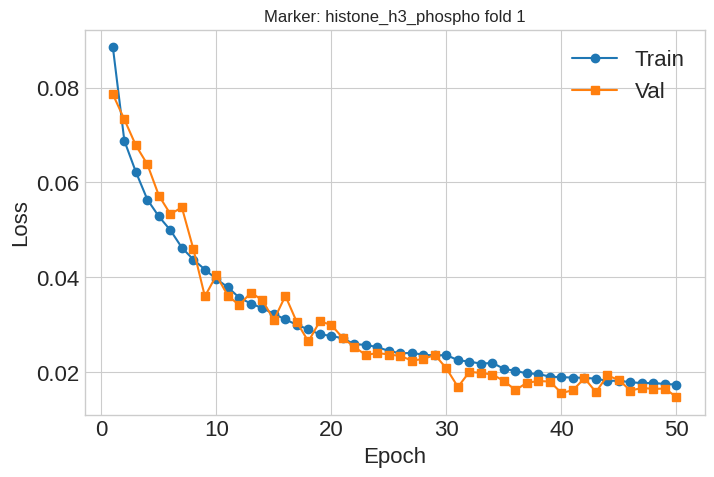

[cache] Saved model checkpoint to ./cv_cache/model_jackson2020_histone_h3_phospho_fold1.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 184 images in the folder /tmp/tmpi86b8jk4


FID tmpi86b8jk4 : 100%|██████████| 92/92 [00:08<00:00, 10.54it/s]


Found 184 images in the folder /tmp/tmpf3_bhbee


FID tmpf3_bhbee : 100%|██████████| 92/92 [00:08<00:00, 11.26it/s]


[cache] Saved fold-1 metrics to ./cv_cache/metrics_jackson2020_histone_h3_phospho_fold1.json
[cv] Fold 2/4, marker histone_h3_phospho ######
[info] example image shape: (481, 542, 35)
[info] extracting control and trg markers: 1 / 551
[info] extracting control and trg markers: 276 / 551
[info] extracting control and trg markers: 551 / 551
[norm] fitting regression: 1 / 551
[norm] fitting regression: 276 / 551
[norm] fitting regression: 551 / 551
[norm] normalization: 1 / 551
[norm] normalization: 276 / 551
[norm] normalization: 551 / 551
[norm] PCA projection to 3D captures 74.89% variance
[cache] Saved preprocessing for fold 2 to ./cv_cache/preproc_jackson2020_histone_h3_phospho_fold2.pkl
[train] Training model for fold 2 ...
Epoch   1 | Train 0.073 | Val 0.073
  ↳ New best val=0.073 at epoch 1
  ↳ Saved checkpoint to best_model.pth
Epoch   2 | Train 0.059 | Val 0.067
  ↳ New best val=0.067 at epoch 2
  ↳ Saved checkpoint to best_model.pth
Epoch   3 | Train 0.052 | Val 0.067
  ↳ No im

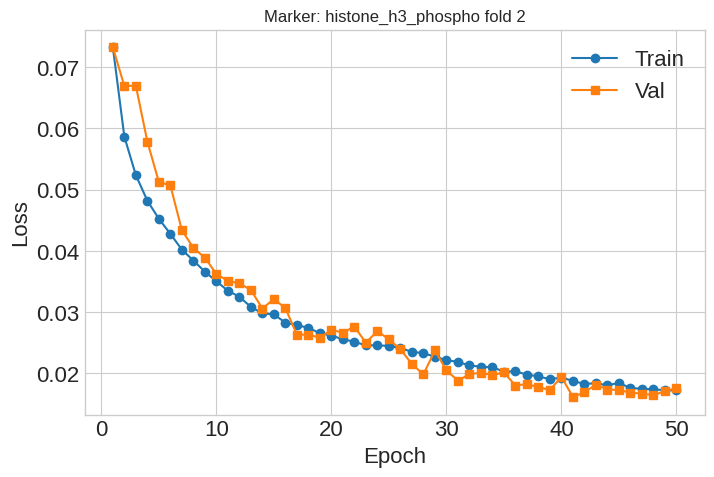

[cache] Saved model checkpoint to ./cv_cache/model_jackson2020_histone_h3_phospho_fold2.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 184 images in the folder /tmp/tmpwr3dzsfz


FID tmpwr3dzsfz : 100%|██████████| 92/92 [00:08<00:00, 10.48it/s]


Found 184 images in the folder /tmp/tmp154f70su


FID tmp154f70su : 100%|██████████| 92/92 [00:08<00:00, 11.03it/s]


[cache] Saved fold-2 metrics to ./cv_cache/metrics_jackson2020_histone_h3_phospho_fold2.json
[cv] Fold 3/4, marker histone_h3_phospho ######
[info] example image shape: (445, 513, 35)
[info] extracting control and trg markers: 1 / 551
[info] extracting control and trg markers: 276 / 551
[info] extracting control and trg markers: 551 / 551
[norm] fitting regression: 1 / 551
[norm] fitting regression: 276 / 551
[norm] fitting regression: 551 / 551
[norm] normalization: 1 / 551
[norm] normalization: 276 / 551
[norm] normalization: 551 / 551
[norm] PCA projection to 3D captures 75.92% variance
[cache] Saved preprocessing for fold 3 to ./cv_cache/preproc_jackson2020_histone_h3_phospho_fold3.pkl
[train] Training model for fold 3 ...
Epoch   1 | Train 0.059 | Val 0.049
  ↳ New best val=0.049 at epoch 1
  ↳ Saved checkpoint to best_model.pth
Epoch   2 | Train 0.045 | Val 0.043
  ↳ New best val=0.043 at epoch 2
  ↳ Saved checkpoint to best_model.pth
Epoch   3 | Train 0.042 | Val 0.041
  ↳ New b

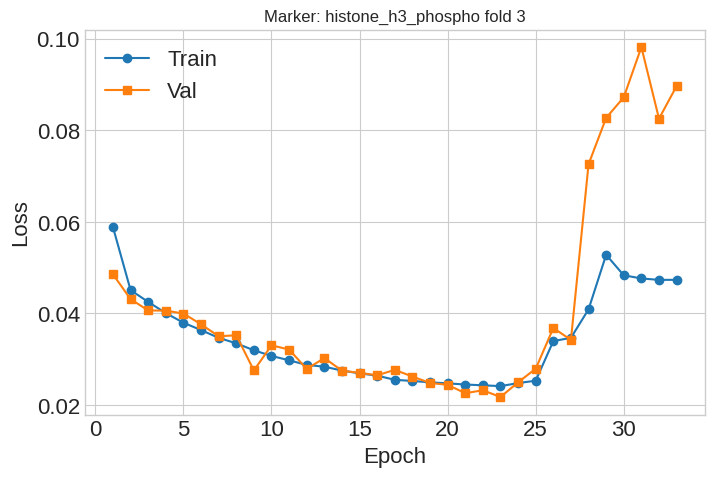

[cache] Saved model checkpoint to ./cv_cache/model_jackson2020_histone_h3_phospho_fold3.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 184 images in the folder /tmp/tmpxpzbmw3g


FID tmpxpzbmw3g : 100%|██████████| 92/92 [00:08<00:00, 10.46it/s]


Found 184 images in the folder /tmp/tmp5il6sdt3


FID tmp5il6sdt3 : 100%|██████████| 92/92 [00:08<00:00, 10.85it/s]


[cache] Saved fold-3 metrics to ./cv_cache/metrics_jackson2020_histone_h3_phospho_fold3.json
[cv] Fold 4/4, marker histone_h3_phospho ######
[info] example image shape: (445, 513, 35)
[info] extracting control and trg markers: 1 / 552
[info] extracting control and trg markers: 277 / 552
[info] extracting control and trg markers: 552 / 552
[norm] fitting regression: 1 / 552
[norm] fitting regression: 277 / 552
[norm] normalization: 1 / 552
[norm] normalization: 277 / 552
[norm] PCA projection to 3D captures 76.75% variance
[cache] Saved preprocessing for fold 4 to ./cv_cache/preproc_jackson2020_histone_h3_phospho_fold4.pkl
[train] Training model for fold 4 ...
Epoch   1 | Train 0.094 | Val 0.100
  ↳ New best val=0.100 at epoch 1
  ↳ Saved checkpoint to best_model.pth
Epoch   2 | Train 0.075 | Val 0.076
  ↳ New best val=0.076 at epoch 2
  ↳ Saved checkpoint to best_model.pth
Epoch   3 | Train 0.077 | Val 0.067
  ↳ New best val=0.067 at epoch 3
  ↳ Saved checkpoint to best_model.pth
Epoch

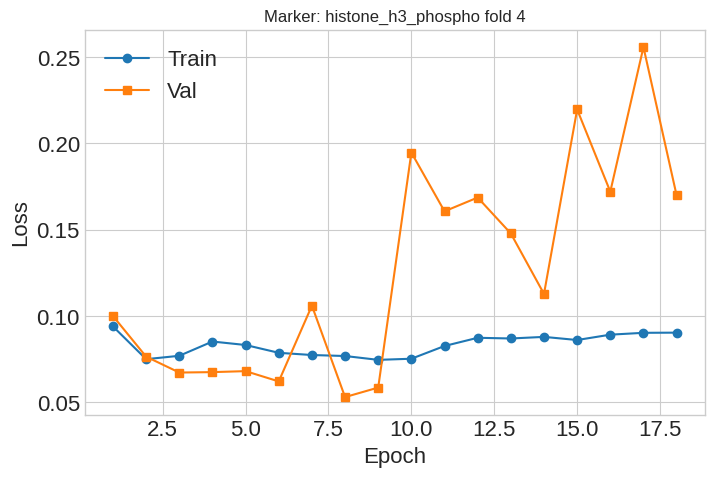

[cache] Saved model checkpoint to ./cv_cache/model_jackson2020_histone_h3_phospho_fold4.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 183 images in the folder /tmp/tmpbaqwbn4_


FID tmpbaqwbn4_ : 100%|██████████| 92/92 [00:08<00:00, 10.39it/s]


Found 183 images in the folder /tmp/tmp7p84nhlv


FID tmp7p84nhlv : 100%|██████████| 92/92 [00:08<00:00, 10.85it/s]


[cache] Saved fold-4 metrics to ./cv_cache/metrics_jackson2020_histone_h3_phospho_fold4.json
[viz] Generating prediction visualizations for BEST fold 2...


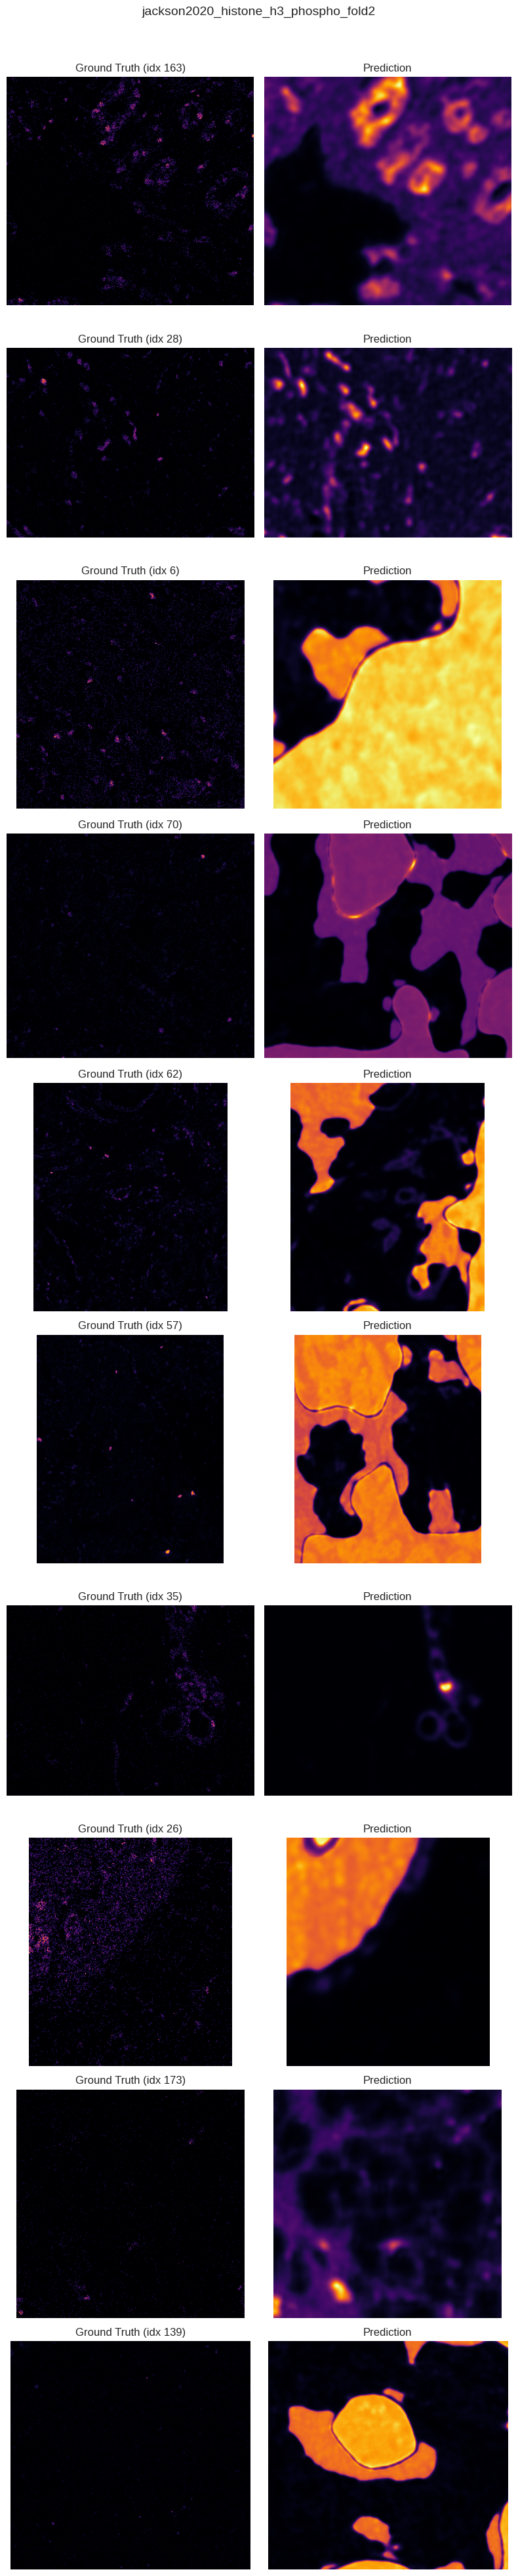

[res] Saved comparison figure to: comparison_grid_jackson2020_histone_h3_phospho_fold2.png
[res] Done training histone_h3_phospho!
Stats: RMSE = 0.178 ± 0.053 | Pearson = -0.070 ± 0.021 | FID = 278.3 ± 28.9
[done] histone_h3_phospho complete in 579.3 minutes



In [8]:
dataset = "jackson2020"
path = f"/kaggle/input/{dataset}"
control = [0, 33, 34] #histone_h3, dna1, dna2

marker_tasks = [
    #("histone_h3_trimethylate", 1, control), #H3K27me3 
    ('histone_h3_phospho', 14, control) #pHH3
]

optimize = False
best_hyperparams = {
    'lr': 3.2e-05,
    'alpha': 0.975}
    
#j_results = []

for idx, (title, target_idx, control_markers_indices) in enumerate(marker_tasks):
    start_time = time.time()
    print(f"\n{'='*10}")
    print(f"Processing: {title} (Marker {idx+1}/{len(marker_tasks)})")
    print(f"{'='*10}\n")
    
    # OPTIMIZE ON FIRST MARKER ONLY
    if idx == 0 and optimize:
        print("[info] Running hyperparameter optimization...")
        best_hyperparams = optimize_for_marker(
            path, target_idx, control_markers_indices, title, dataset,
            cache_dir=WORK_CACHE_ROOT
        )
        
        print(f"\n [res] Best hyperparameters:")
        print(f"   lr: {best_hyperparams['lr']:.2e}")
        print(f"   alpha: {best_hyperparams['alpha']:.3f}\n")
        
        with open(f'{dataset}_best_hyperparams.json', 'w') as f:
            json.dump(best_hyperparams, f, indent=2)
    
    print(f"[info] Training {title}...")
    res = main(
        path, target_idx, control_markers_indices,
        title=title, data_name=dataset,
        hyperparams=best_hyperparams 
    )
    
    df_res = pd.DataFrame([res])
    df_res.to_csv(f"{dataset}_results_{title}_optimized.csv", index=False)
    #j_results.append(res)
    
    elapsed = (time.time() - start_time) / 60
    print(f"[done] {title} complete in {elapsed:.1f} minutes\n")
